In [10]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading and Visualizing the Shape File

In [11]:
shape_file=gpd.read_file(r"C:\Users\pooja\Desktop\Sentinel 2A\crop_classification_mhow_road_Ambachandn.shp")

In [12]:
print(shape_file)

    Crop_class                                           geometry
0        chana  POLYGON ((75.83191 22.54246, 75.83235 22.54236...
1       Garlic  POLYGON ((75.83238 22.54234, 75.83324 22.54199...
2        chana  POLYGON ((75.83257 22.54307, 75.83244 22.54251...
3      G_Onion  POLYGON ((75.83362 22.54201, 75.83482 22.54171...
4        Onion  POLYGON ((75.83369 22.54307, 75.83491 22.54292...
..         ...                                                ...
142      onion  POLYGON ((75.91210 22.52371, 75.91407 22.52360...
143      wheat  POLYGON ((75.90728 22.52392, 75.90934 22.52337...
144     Garlic  POLYGON ((75.83306 22.54251, 75.83304 22.54296...
145      Wheat  POLYGON ((75.83066 22.54358, 75.83208 22.54395...
146    G_Onion  POLYGON ((75.83135 22.54346, 75.83171 22.54356...

[147 rows x 2 columns]


<AxesSubplot: >

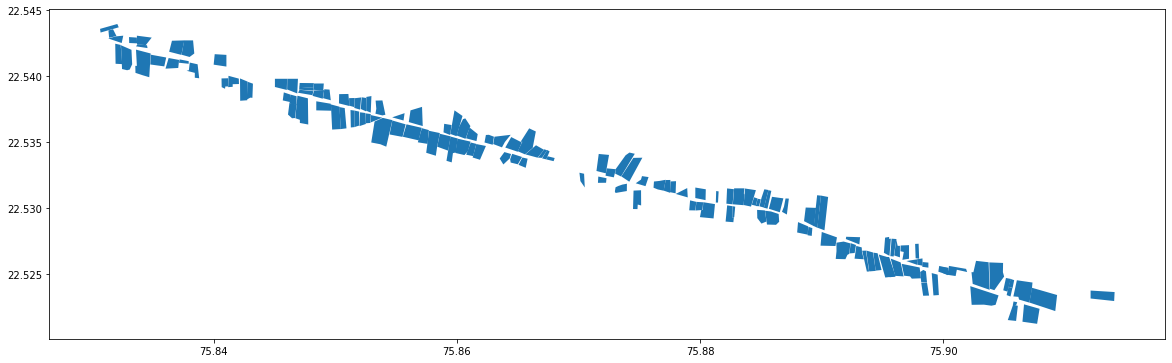

In [13]:
shape_file.plot(figsize=(20,20))

In [14]:
print(shape_file.columns)

Index(['Crop_class', 'geometry'], dtype='object')


<AxesSubplot: >

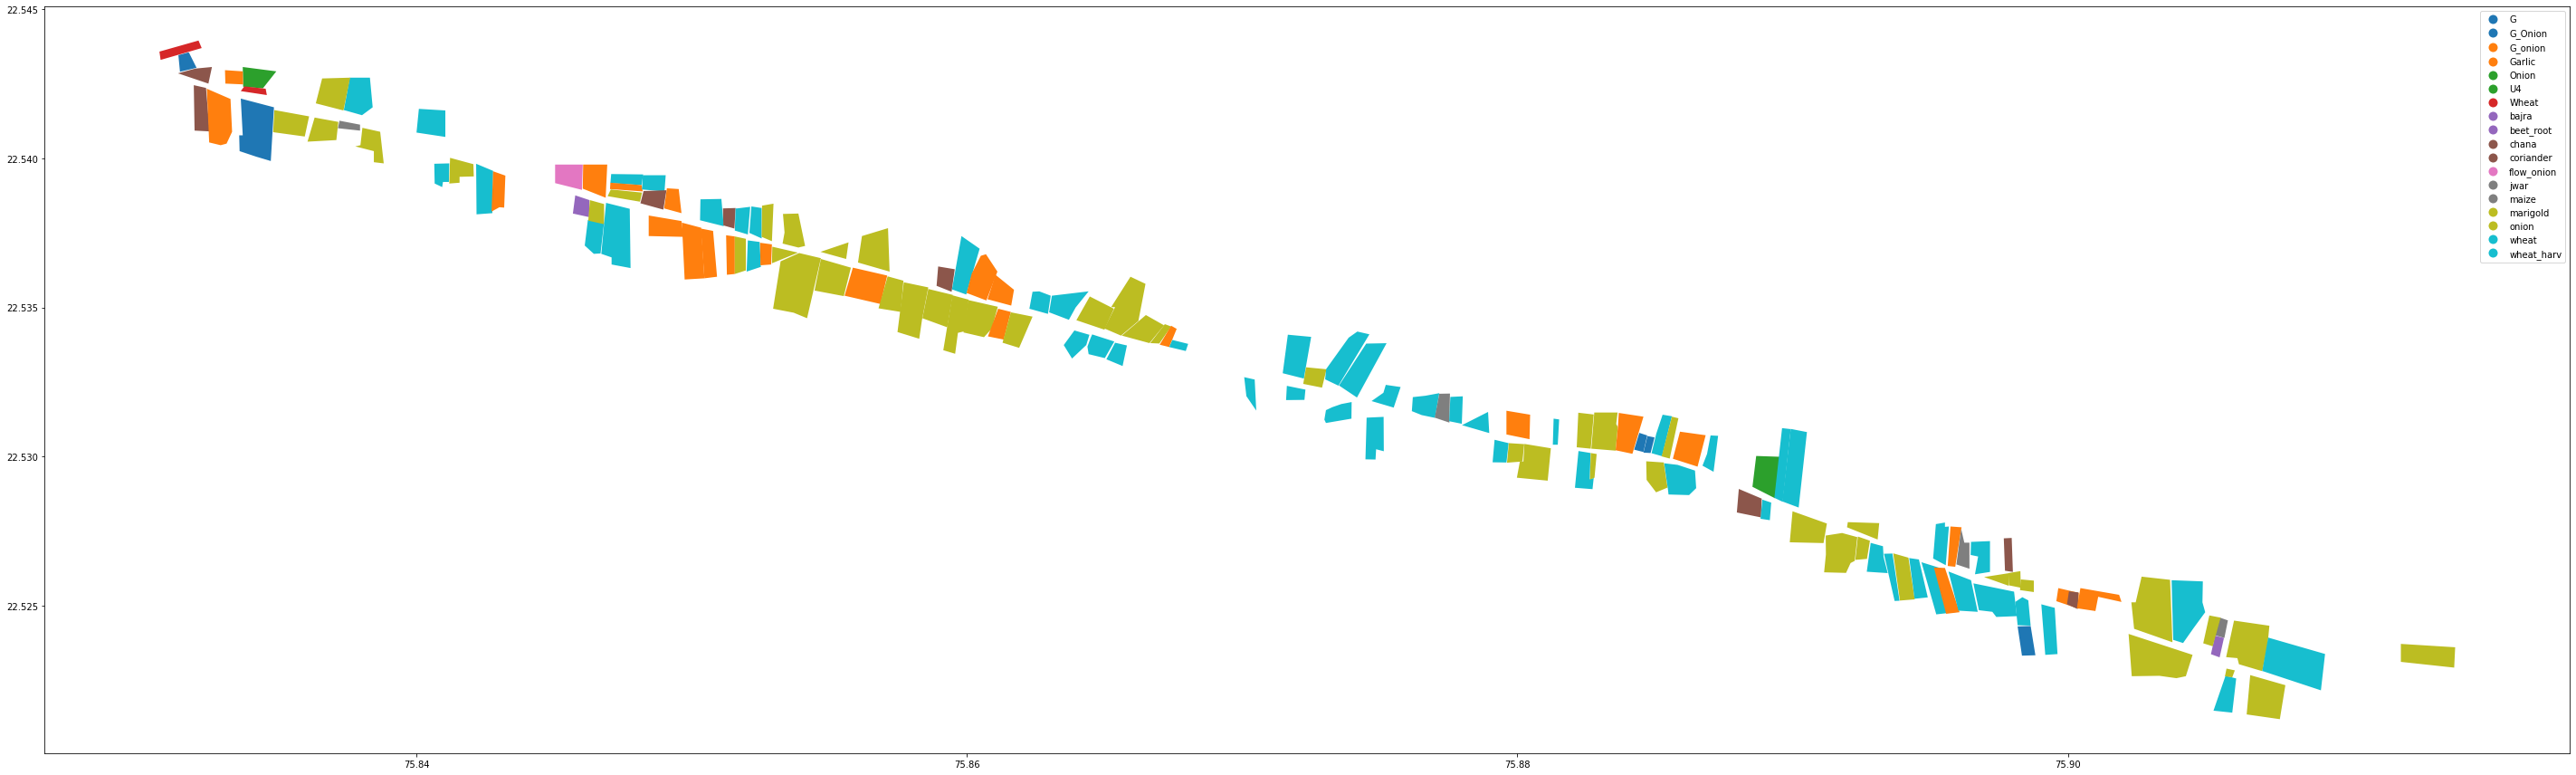

In [15]:
shape_file.plot(column='Crop_class',cmap=None,legend=True,figsize=(50,50))

# Identifying the boundaries of each Polygon in the Shape File

In [7]:
import geopandas as gpd

# Read the shapefile into a GeoDataFrame
gdf = gpd.read_file(r"C:\Users\pooja\Desktop\Sentinel 2A\crop_classification_mhow_road_Ambachandn.shp")

# Loop through each polygon in the GeoDataFrame
for i, row in gdf.iterrows():
    # Get the polygon object for this row
    poly = row['geometry']
    
    # Get the coordinates of the vertices and print them
    coords = poly.exterior.coords[:]
    print(f"Polygon {i} vertices:")
    for coord in coords:
        lat, lon = coord
        print(f"({lat}, {lon})")

Polygon 0 vertices:
(75.83191010964302, 22.542456063260794)
(75.83235488117217, 22.542363304405846)
(75.83248400839032, 22.540905657070592)
(75.83193880458037, 22.5409321598868)
(75.83191010964302, 22.542456063260794)
Polygon 1 vertices:
(75.83238357610954, 22.5423368018644)
(75.83324442423049, 22.541992268362662)
(75.83324442423049, 22.541992268362662)
(75.83330181410521, 22.540892405660582)
(75.83310094954365, 22.540494862768753)
(75.83288573751342, 22.540441856963337)
(75.83246966092162, 22.540534617109454)
(75.83238357610954, 22.5423368018644)
Polygon 2 vertices:
(75.8325700932024, 22.543065619899814)
(75.83244096598428, 22.5425090682928)
(75.83133621089571, 22.542853600504603)
(75.83196749951775, 22.54301261508154)
(75.8325700932024, 22.543065619899814)
Polygon 3 vertices:
(75.83361745841623, 22.5420055196671)
(75.83482264578556, 22.541713990675813)
(75.8347078660361, 22.539911797789888)
(75.8347078660361, 22.539911797789888)
(75.83417700969483, 22.540057564265478)
(75.83357441601

# Downloading the Sentinel 2 Data 

Downloaded the requisite files using the Sentinel API. The API allows for me to specify the dates, as well as the coordinates of the shape file. This downloads only the requisite tiles, and makes it easier to clean up, when it comes to extracting multiple reflectance values. 


Currently commented out, since I've already downloaded the data- which takes quite a bit of time

In [ ]:
'''from sentinelsat import SentinelAPI, geojson_to_wkt
from shapely.geometry import shape
import geopandas as gpd

# Set up the API
api = SentinelAPI('poojapremnath', 'Pooj@2003ssn', 'https://scihub.copernicus.eu/dhus')


shapefile_path = r'C:\Users\pooja\Desktop\Sentinel 2A\crop_classification_mhow_road_Ambachandn.shp'

# Read in the shapefile as a GeoDataFrame
gdf = gpd.read_file(shapefile_path)


for index, row in gdf.iterrows():
    
    wkt = geojson_to_wkt(row.geometry.__geo_interface__)
    
    
    date_range = ('2023-02-15T00:00:00Z', '2023-02-28T23:59:59Z')  
    platform = 'Sentinel-2'
    product_type = 'S2MSI2A'
    cloudcover_percentage = (0, 10)  # Change as needed
    
    
    products = api.query(wkt,
                         date=date_range,
                         platformname=platform,
                         producttype=product_type,
                         cloudcoverpercentage=cloudcover_percentage)
    
    
    api.download_all(products)'''

This section processes the ZIP folders that come from the Sentinel 2 data download. It extracts the ZIP files, and gives access to the .SAFE files

**I have used data from the second half of February (15th to 28th February 2023). There are 4 tiles that are downloaded for this period. **

In [16]:
import os
import zipfile

# Define path to the directory containing the downloaded granules
granules_dir = r'C:\Users\pooja\Desktop\Sentinel 2A'

# Loop over the granules and extract the zip files
for granule_name in os.listdir(granules_dir):
    granule_path = os.path.join(granules_dir, granule_name)
    if granule_name.endswith('.zip'):
        with zipfile.ZipFile(granule_path, 'r') as zip_ref:
            zip_ref.extractall(granules_dir)
        os.remove(granule_path)

# Clipping the Sentinel Data to that of the Shape File

In this section, I have used the rasterio module to map the data from the Sentinel Download, to the shape of the Shape File. This is the outline of the block below:

1. Initially, I have to make sure that the Shape file and the Sentinel Data are in the same Coordinate Reference System (CRS). If not, an appropriate mapping is done. 

2. I recursively iterate through the folders on my system to identify the required images, from each tile. I have used the Red, Green, Blue and NIR Bands. 

3. I clip the Sentinel Data to that of the shape file using the mask function. I've also included a try-catch error detection block in case, there are regions that cannot be found. (Upon running, it is clear that all the fields in the Sentinel Data are mapped to the shape file as well, so that is not an issue). 



In [ ]:
import os
import glob
import rasterio
from rasterio.plot import show
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

path = r'C:\Users\pooja\Desktop\Sentinel 2A'

# Read in the shapefile
shapefile_path = r'C:\Users\pooja\Desktop\Sentinel 2A\crop_classification_mhow_road_Ambachandn.shp'
gdf = gpd.read_file(shapefile_path)


if gdf.crs != rasterio.crs.CRS.from_epsg(32643):
    gdf = gdf.to_crs(rasterio.crs.CRS.from_epsg(32643))


folders = glob.glob(os.path.join(path, '**/*.SAFE'), recursive=True)



# Loop through each .SAFE folder
for folder in folders:
    
    band_paths = [os.path.join(folder, 'GRANULE', granule, 'IMG_DATA', 'R10m', file) for granule in os.listdir(os.path.join(folder, 'GRANULE')) for file in os.listdir(os.path.join(folder, 'GRANULE', granule, 'IMG_DATA', 'R10m')) if file.endswith('_B02_10m.jp2') or file.endswith('_B03_10m.jp2') or file.endswith('_B04_10m.jp2') or file.endswith('_B08_10m.jp2')]
    
   
    arrs = []
    for band_path in band_paths:
        with rasterio.open(band_path) as src:
            arrs.append(src.read(1))
            
    arr = np.stack(arrs, axis=-1)
    
    # Loop through each feature in the shapefile
    for index, row in gdf.iterrows():
        # Clip the array to the extent of the feature
        try:
            out_image, out_transform = mask(rasterio.open(band_paths[0]), [row.geometry], crop=True)
        except ValueError:
            print(f"Skipping feature {index} as it does not overlap raster")
            continue
        
        for i in range(1, arr.shape[-1]):
            try:
                band_image, _ = mask(rasterio.open(band_paths[i]), [row.geometry], crop=True)
            except ValueError:
                print(f"Skipping feature {index} as it does not overlap raster")
                continue
            out_image = np.dstack((out_image, band_image))
        
        
        

# Computing Reflectance Values & Creation of ML Input Dataset

In this section, I have again read through the clipped images, and have computed the reflectance values. These are then put into a CSV file. The structure of the CSV file is as follows:

Crop_Class | B02 Reflectance Val | B03 Reflectance Val | B04 Reflectance Val | B08 Reflectance Val

There are 4 tiles which were downloaded. For each tile, an indivudual output.csv file is created. 

I have merged all 4 of those files to create a single dataset. 


In [ ]:

path = r'C:\Users\pooja\Desktop\Sentinel 2A'

shapefile_path = r'C:\Users\pooja\Desktop\Sentinel 2A\crop_classification_mhow_road_Ambachandn.shp'
gdf = gpd.read_file(shapefile_path)


if gdf.crs != rasterio.crs.CRS.from_epsg(32643):
    gdf = gdf.to_crs(rasterio.crs.CRS.from_epsg(32643))


folders = glob.glob(os.path.join(path, '**/*.SAFE'), recursive=True)


band_names = ['B02', 'B03', 'B04', 'B08']


for folder in folders:
    # Construct the file paths for each band
    band_paths = [os.path.join(folder, 'GRANULE', granule, 'IMG_DATA', 'R10m', file) for granule in os.listdir(os.path.join(folder, 'GRANULE')) for file in os.listdir(os.path.join(folder, 'GRANULE', granule, 'IMG_DATA', 'R10m')) if file.endswith('_B02_10m.jp2') or file.endswith('_B03_10m.jp2') or file.endswith('_B04_10m.jp2') or file.endswith('_B08_10m.jp2')]
    
    # Read in the bands and stack them into a single array
    arrs = []
    for band_path in band_paths:
        with rasterio.open(band_path) as src:
            arrs.append(src.read(1))
    arr = np.stack(arrs, axis=-1)
    
    
    data_rows = []
    for index, row in gdf.iterrows():
        
        try:
            out_image, out_transform = mask(rasterio.open(band_paths[0]), [row.geometry], crop=True)
        except ValueError:
            print(f"Skipping feature {index} as it does not overlap raster")
            continue
        
        for i in range(1, arr.shape[-1]):
            try:
                band_image, _ = mask(rasterio.open(band_paths[i]), [row.geometry], crop=True)
            except ValueError:
                print(f"Skipping feature {index} as it does not overlap raster")
                continue
            out_image = np.dstack((out_image, band_image))
        
       
        crop_class = row['Crop_class']
        
        
        data_rows.extend([(crop_class,) + tuple(pixel) for pixel in out_image.reshape(-1, 4)])
    
    # Create a pandas DataFrame from the data rows
    import pandas as pd
    df = pd.DataFrame(data_rows, columns=['Crop_class'] + [f'{band}_refl' for band in band_names])
    
    # Write the DataFrame to a CSV file
    csv_path = os.path.join(folder, 'output.csv')
    df.to_csv(csv_path, index=False)



# Preliminary Analysis of Dataset of Reflectance Values

In this section, I analyze the number of valid pixels for each type of crop. I've merged the output.csv files from each tile, into a single csv called reflectance_sentinel.csv.


In all there are 83,320 rows, each with reflectance values for the chosen bands. 

In [17]:
import pandas as pd


df = pd.read_csv('reflectance_sentinel.csv')


crop_types = df['Crop_class'].unique()

crop_sum=0

for crop_type in crop_types:
    count = df[df['Crop_class'] == crop_type].shape[0]
    print(f'{crop_type}: {count} records')
    crop_sum+=count
    
print(crop_sum)

chana: 2076 records
Garlic: 8492 records
G_Onion: 1688 records
Onion: 504 records
Wheat: 720 records
onion: 31344 records
maize: 876 records
wheat: 29880 records
G_onion: 3620 records
beet_root: 252 records
flow_onion: 484 records
wheat_harv: 892 records
marigold: 176 records
G: 716 records
coriander: 480 records
U4: 748 records
jwar: 192 records
bajra: 180 records
83320


In [18]:
print(len(crop_types))

18


In [19]:
print(df.columns)

Index(['Crop_class', 'B02_refl', 'B03_refl', 'B04_refl', 'B08_refl'], dtype='object')


# Replacing and Merging Redundant Crop Names

There are some crop names which are redundant. For example, there's both G_onion and G_Onion, as well as Onion and onion. 

In [20]:
df['Crop_class'] = df['Crop_class'].replace('G_onion', 'G_Onion')
df['Crop_class'] = df['Crop_class'].replace('Onion', 'onion')

In [21]:
#Updated crop count for each type


crop_types = df['Crop_class'].unique()
for crop_type in crop_types:
    count = df[df['Crop_class'] == crop_type].shape[0]
    print(f'{crop_type}: {count} records')

chana: 2076 records
Garlic: 8492 records
G_Onion: 5308 records
onion: 31848 records
Wheat: 720 records
maize: 876 records
wheat: 29880 records
beet_root: 252 records
flow_onion: 484 records
wheat_harv: 892 records
marigold: 176 records
G: 716 records
coriander: 480 records
U4: 748 records
jwar: 192 records
bajra: 180 records


In [22]:
print(len(crop_types))

16


# Removal of NULL Values

There are some rows where all the reflectance values are 0. These have been identified and removed, as it might mess up the ML model. 

In [23]:
all_zero_rows = df[(df['B02_refl'] == 0) & (df['B03_refl'] == 0) & (df['B04_refl'] == 0) & (df['B08_refl'] == 0)]


print(f"Count of all-zero rows: {len(all_zero_rows)}")


Count of all-zero rows: 18372


In [24]:
df = df.drop(all_zero_rows.index)

# Scaling Reflectance Values

For the sake of the ML model, it is best to normalize the reflectance values between -1 and 1, since sometimes the magnitude of the actual value can cause incorrect training. Prevents the model from leaning towards any particular answer, just because the values are marginally larger. 

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [26]:
scaler = StandardScaler()
X = df[['B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']]
X_scaled = scaler.fit_transform(X)
df[['B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']] = X_scaled

In [27]:
#Printing the first five records of the rescaled reflectance values
print(df.head())

  Crop_class  B02_refl  B03_refl  B04_refl  B08_refl
0      chana  0.046812 -0.005913 -1.291820 -1.226364
1      chana -1.192846 -1.293899 -1.291820  0.275336
2      chana  0.288523 -1.293899 -1.291820 -1.226364
3      chana -1.192846 -1.293899  0.292802  0.364896
5      chana -1.192846  1.384136  1.555462 -1.226364


# Exploratory Data Analysis

In [28]:
print(df.describe())

           B02_refl      B03_refl      B04_refl      B08_refl
count  6.494800e+04  6.494800e+04  6.494800e+04  6.494800e+04
mean  -6.651629e-17 -1.067761e-16 -1.172787e-16  8.927186e-17
std    1.000008e+00  1.000008e+00  1.000008e+00  1.000008e+00
min   -1.192846e+00 -1.293899e+00 -1.291820e+00 -1.226364e+00
25%   -1.192846e+00 -3.428129e-01 -3.558409e-01 -1.226364e+00
50%    6.369617e-02  9.441395e-03  1.418397e-03  5.731843e-02
75%    2.982981e-01  2.542130e-01  2.550298e-01  2.934292e-01
max    4.609109e+00  4.704359e+00  4.587108e+00  4.642028e+00


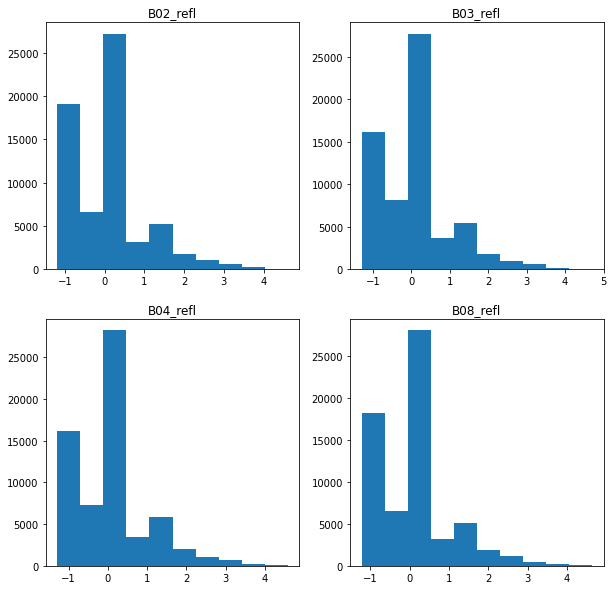

In [29]:
#Histograms to visualize diff bands
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(df['B02_refl'])
axs[0, 0].set_title('B02_refl')
axs[0, 1].hist(df['B03_refl'])
axs[0, 1].set_title('B03_refl')
axs[1, 0].hist(df['B04_refl'])
axs[1, 0].set_title('B04_refl')
axs[1, 1].hist(df['B08_refl'])
axs[1, 1].set_title('B08_refl')

plt.show()

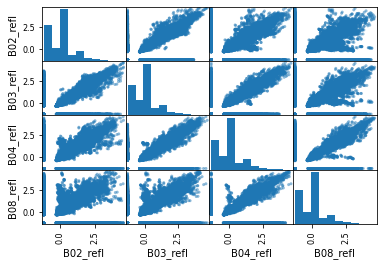

In [30]:
#Scatter Plot to check for any blatantly obvious abnormal correlations
from pandas.plotting import scatter_matrix


scatter_matrix(df[['Crop_class', 'B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']], diagonal='hist')

plt.show()


# Outlier Detection

The presence of anomalous reflectance values is identified by taking Z-Score values. 
It measures how many standard deviations above or below the mean, a given data point is.
If z>3, it is likely to be an anomalous value, and may affect the training of the model. 


This segment identifies anomalous rows for each crop, and removes it from the dataframe. 

In [31]:
import numpy as np
crop_types = df['Crop_class'].unique()


for crop in crop_types:
    
    crop_df = df[df['Crop_class'] == crop]
    
    
    z_scores = np.abs((crop_df - crop_df.mean()) / crop_df.std(ddof=0))
    
    
    outlier_mask = (z_scores > 3).any(axis=1)
    outlier_rows = crop_df[outlier_mask]
    
    
    df = df.drop(outlier_rows.index)
    
   
    print(f'Outliers for {crop}: {len(outlier_rows)}')
    print(outlier_rows)

C:\Users\pooja\AppData\Local\Temp\ipykernel_68644\3219893085.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scores = np.abs((crop_df - crop_df.mean()) / crop_df.std(ddof=0))
C:\Users\pooja\AppData\Local\Temp\ipykernel_68644\3219893085.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scores = np.abs((crop_df - crop_df.mean()) / crop_df.std(ddof=0))
C:\Users\pooja\AppData\Local\Temp\ipykernel_68644\3219893085.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scores = n

Outliers for chana: 2
      Crop_class  B02_refl  B03_refl  B04_refl  B08_refl
41680      chana  2.856703  2.889798  -1.29182 -1.226364
62510      chana  2.873588  2.904249  -1.29182 -1.226364
Outliers for Garlic: 122
      Crop_class  B02_refl  B03_refl  B04_refl  B08_refl
15977     Garlic -1.192846 -1.293899  2.880177  1.540926
15988     Garlic -1.192846 -1.293899  3.056446  2.050238
16010     Garlic -1.192846 -1.293899 -1.291820  2.815562
16021     Garlic -1.192846 -1.293899 -1.291820  3.014583
16032     Garlic -1.192846 -1.293899 -1.291820  2.859890
...          ...       ...       ...       ...       ...
78796     Garlic  2.674531  3.157149 -1.291820 -1.226364
78802     Garlic  2.859369  3.290825 -1.291820 -1.226364
78808     Garlic  2.983779  3.319728 -1.291820 -1.226364
78814     Garlic  3.154399  3.352244 -1.291820 -1.226364
78820     Garlic  2.980225  3.276374 -1.291820 -1.226364

[122 rows x 5 columns]
Outliers for G_Onion: 43
      Crop_class  B02_refl  B03_refl  B04_refl  B

C:\Users\pooja\AppData\Local\Temp\ipykernel_68644\3219893085.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scores = np.abs((crop_df - crop_df.mean()) / crop_df.std(ddof=0))
C:\Users\pooja\AppData\Local\Temp\ipykernel_68644\3219893085.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scores = np.abs((crop_df - crop_df.mean()) / crop_df.std(ddof=0))
C:\Users\pooja\AppData\Local\Temp\ipykernel_68644\3219893085.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scores = n

Outliers for onion: 346
      Crop_class  B02_refl  B03_refl  B04_refl  B08_refl
4810       onion  1.720128  2.702832  2.664338  2.212168
4821       onion  1.767226  3.319728  3.428769  2.573119
4832       onion  1.784110  3.016248  2.673331  1.485743
5294       onion -1.192846 -1.293899 -1.291820  2.710624
5312       onion -1.192846 -1.293899 -1.291820  3.494946
...          ...       ...       ...       ...       ...
81887      onion -1.192846  1.793293  2.776754  3.195511
81904      onion -1.192846  2.169031  2.999788  3.213603
81921      onion -1.192846  2.369545  3.147278  3.058006
81938      onion  1.800106  2.481544  3.050151  2.717861
81955      onion  1.890748  2.383997  2.744378  2.328867

[346 rows x 5 columns]
Outliers for Wheat: 0
Empty DataFrame
Columns: [Crop_class, B02_refl, B03_refl, B04_refl, B08_refl]
Index: []
Outliers for maize: 21
      Crop_class  B02_refl  B03_refl  B04_refl  B08_refl
11458      maize  3.879532  4.089268  3.979160 -1.226364
11465      maize  3.9

C:\Users\pooja\AppData\Local\Temp\ipykernel_68644\3219893085.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scores = np.abs((crop_df - crop_df.mean()) / crop_df.std(ddof=0))
C:\Users\pooja\AppData\Local\Temp\ipykernel_68644\3219893085.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scores = np.abs((crop_df - crop_df.mean()) / crop_df.std(ddof=0))
C:\Users\pooja\AppData\Local\Temp\ipykernel_68644\3219893085.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scores = n

Outliers for wheat: 463
      Crop_class  B02_refl  B03_refl  B04_refl  B08_refl
4515       wheat  3.428101  3.587080  3.262393  3.047150
4535       wheat  3.617382  3.770433  3.294769  2.132560
4540       wheat  4.019049  4.008882  3.370313  1.781560
4545       wheat  4.147014  4.082043  3.661696  2.252877
4550       wheat  3.752456  3.959205  3.709360  2.539647
...          ...       ...       ...       ...       ...
79843      wheat -1.192846 -1.293899  3.186849  3.879418
79844      wheat  3.730240  3.619596  2.582499 -1.226364
79850      wheat -1.192846 -1.293899  3.096916  3.857706
79851      wheat  3.648485  3.590693  2.550123 -1.226364
82843      wheat  3.392556  3.294438  3.168862  2.978397

[463 rows x 5 columns]
Outliers for beet_root: 0
Empty DataFrame
Columns: [Crop_class, B02_refl, B03_refl, B04_refl, B08_refl]
Index: []
Outliers for flow_onion: 0
Empty DataFrame
Columns: [Crop_class, B02_refl, B03_refl, B04_refl, B08_refl]
Index: []
Outliers for wheat_harv: 0
Empty DataFr

C:\Users\pooja\AppData\Local\Temp\ipykernel_68644\3219893085.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scores = np.abs((crop_df - crop_df.mean()) / crop_df.std(ddof=0))
C:\Users\pooja\AppData\Local\Temp\ipykernel_68644\3219893085.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scores = np.abs((crop_df - crop_df.mean()) / crop_df.std(ddof=0))
C:\Users\pooja\AppData\Local\Temp\ipykernel_68644\3219893085.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scores = n

In [32]:
# New  number of rows
print(len(df))

63946


In [33]:
#making a copy of this dataframe, for futher use in different models
ndf=df.copy(deep=True)
ndf2=df.copy(deep=True)

In [34]:
crop_types = df['Crop_class'].unique()


for crop_type in crop_types:
    count = df[df['Crop_class'] == crop_type].shape[0]
    print(f'{crop_type}: {count} records')


chana: 1686 records
Garlic: 6834 records
G_Onion: 4057 records
onion: 24278 records
Wheat: 388 records
maize: 683 records
wheat: 22593 records
beet_root: 208 records
flow_onion: 368 records
wheat_harv: 756 records
marigold: 144 records
G: 641 records
coriander: 360 records
U4: 618 records
jwar: 176 records
bajra: 156 records


# ML Modeling Techniques

In [35]:
crop_types = df['Crop_class'].unique()
print(crop_types)

['chana' 'Garlic' 'G_Onion' 'onion' 'Wheat' 'maize' 'wheat' 'beet_root'
 'flow_onion' 'wheat_harv' 'marigold' 'G' 'coriander' 'U4' 'jwar' 'bajra']


# Decision Tree Classifier

Supervised modeling technique- nodes represent the features of the dataset, branches represent rules/possibilities, and the leaf node is the result/outcome

Training Sample: 0.6
Testing Sample 0.4

Iteratively, increases accuracy till the 0.9 mark

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score





df = df[['Crop_class', 'B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']]


le = LabelEncoder()
df['Crop_class'] = le.fit_transform(df['Crop_class'])


X_train, X_test, y_train, y_test = train_test_split(df.drop('Crop_class', axis=1), df['Crop_class'], test_size=0.4, random_state=42)


model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


while accuracy < 0.9:
    
    onion_indices = df[df['Crop_class'] == le.transform(['onion'])[0]].index

    # Split the data into training and testing sets, ensuring that there are onion crops in both sets
    X_train = df[df.index.isin(onion_indices) | ~df['Crop_class'].isin(onion_indices)].drop('Crop_class', axis=1)
    y_train = df[df.index.isin(onion_indices) | ~df['Crop_class'].isin(onion_indices)]['Crop_class']
    X_test = df[df.index.isin(onion_indices)].drop('Crop_class', axis=1)
    y_test = df[df.index.isin(onion_indices)]['Crop_class']

   
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)


print(f"Final accuracy: {accuracy}")


Final accuracy: 0.9711673119696845


# Evaluation of Decision Tree Classifier

Metrics like accuracy, precision, recall and F1 Score along with the training and testing R2 Score. The Gini Importance among different input fields (here, the reflectance values is also analyzed)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9711673119696845
Precision: 1.0
Recall: 0.9711673119696845
F1 Score: 0.9853727850217319


C:\Users\pooja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train R2 score: 0.8670403551232492
Test R2 score: 0.0


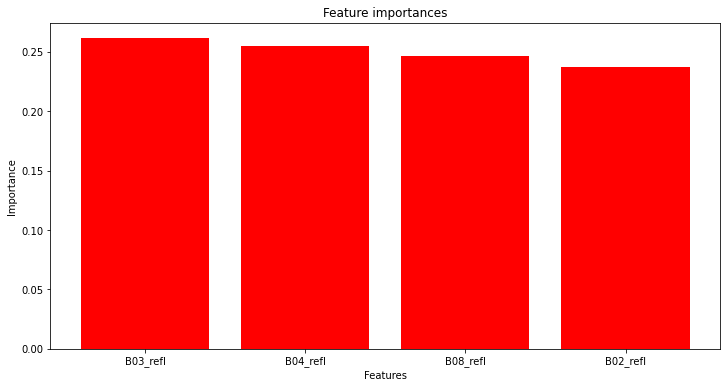

In [38]:
from sklearn.metrics import r2_score, log_loss
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# R2 score
y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
y_pred_test = model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Train R2 score: {r2_train}")
print(f"Test R2 score: {r2_test}")


# Gini importance
features = ['B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices], color="r", align="center")
plt.xticks(range(len(features)), [features[i] for i in indices])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


# Support Vector Machine

Helps in the categorization of data points, even when the fields are not linearly separable

Iteration done till 85% accuracy (enters an endless loop, if I try to make the accuracy any more)

Training Set: 0.6
Testing Set: 0.4

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


ndf = ndf[['Crop_class', 'B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']]

le = LabelEncoder()
ndf['Crop_class'] = le.fit_transform(ndf['Crop_class'])

X_train, X_test, y_train, y_test = train_test_split(ndf.drop('Crop_class', axis=1), ndf['Crop_class'], test_size=0.4, random_state=42)

model = SVC(kernel='linear', C=1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Iterate to improve accuracy
while accuracy < 0.85:
    onion_indices = ndf[ndf['Crop_class'] == le.transform(['onion'])[0]].index

    # Split the data into training and testing sets, ensuring that there are onion crops in both sets
    X_train = ndf[df.index.isin(onion_indices) | ~ndf['Crop_class'].isin(onion_indices)].drop('Crop_class', axis=1)
    y_train = ndf[df.index.isin(onion_indices) | ~ndf['Crop_class'].isin(onion_indices)]['Crop_class']
    X_test = ndf[df.index.isin(onion_indices)].drop('Crop_class', axis=1)
    y_test = ndf[df.index.isin(onion_indices)]['Crop_class']

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    

print(f"Final accuracy: {accuracy}")


Final accuracy: 0.8660103797676909


# Evaluation of SVM

Among the three models I decided to use, SVM has the leat accuracy, but perhaps is also the least susceptible to overfitting. 

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8660103797676909
Precision: 1.0
Recall: 0.8660103797676909
F1 Score: 0.928194600799064


C:\Users\pooja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest Classifier

Works on the principle of multiple decision trees, taking majority votes for classification

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



ndf2 = ndf2[['Crop_class', 'B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']]


le = LabelEncoder()
ndf2['Crop_class'] = le.fit_transform(ndf2['Crop_class'])


X_train, X_test, y_train, y_test = train_test_split(ndf2.drop('Crop_class', axis=1), ndf2['Crop_class'], test_size=0.4, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Iterate to improve accuracy
while accuracy < 0.9:
    
    onion_indices = ndf2[ndf2['Crop_class'] == le.transform(['onion'])[0]].index

    # Split the data into training and testing sets, ensuring that there are onion crops in both sets
    X_train = ndf2[df.index.isin(onion_indices) | ~ndf2['Crop_class'].isin(onion_indices)].drop('Crop_class', axis=1)
    y_train = ndf2[df.index.isin(onion_indices) | ~ndf2['Crop_class'].isin(onion_indices)]['Crop_class']
    X_test = ndf2[df.index.isin(onion_indices)].drop('Crop_class', axis=1)
    y_test = ndf2[df.index.isin(onion_indices)]['Crop_class']

    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    
print(f"Final accuracy: {accuracy}")


Final accuracy: 0.9696021089051816


# Evaluation of Random Forest

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9696021089051816
Precision: 1.0
Recall: 0.9696021089051816
F1 Score: 0.9845664812413735


C:\Users\pooja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train R2 score: 0.8725537265086125
Test R2 score: 0.0


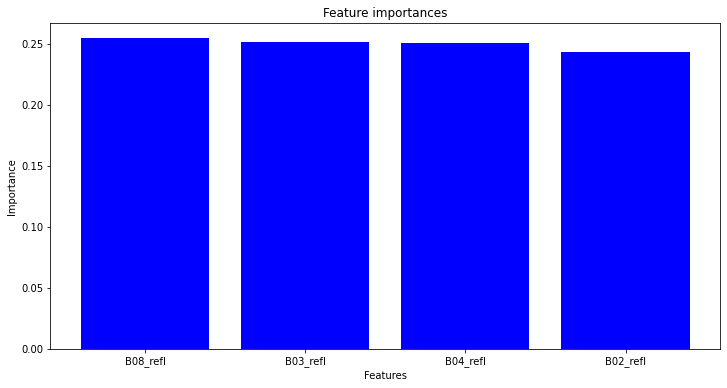

In [45]:
from sklearn.metrics import r2_score, log_loss
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# R2 score
y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
y_pred_test = model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Train R2 score: {r2_train}")
print(f"Test R2 score: {r2_test}")


# Gini importance
features = ['B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices], color="b", align="center")
plt.xticks(range(len(features)), [features[i] for i in indices])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()